In [2]:
import json
import numpy as np
from pp_utils import TimeStepStats, LinearSolveStats
from matplotlib import pyplot as plt
from plot_utils import *

def load_data(path) -> Sequence[TimeStepStats]:
    with open(path, "r") as f:
        payload = json.load(f)
    return [TimeStepStats.from_json(x) for x in payload]

dataset = {
    # 'baseline': load_data("../stats/fpm_0_open.json"),
    # 'rprec': load_data("../stats/fpm_0_open_rprec.json"),

    # 'baseline': load_data("../stats/fpm_0_sliding.json"),
    # 'rprec': load_data("../stats/fpm_0_sliding_rprec.json"),

    'baseline': load_data("../stats/fpm_2_sliding.json"),
}
data = dataset['baseline']

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


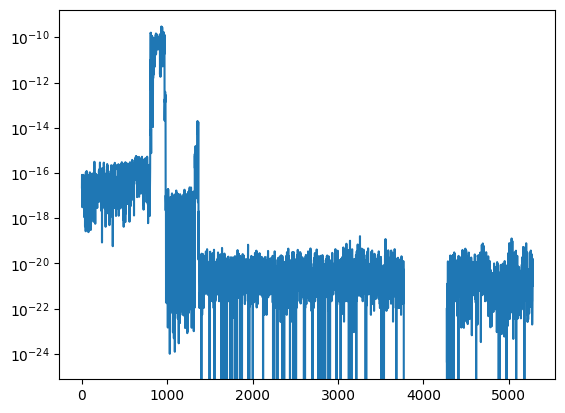

In [3]:
import scipy.sparse
from pathlib import Path
from plot_utils import *


def load_matrix_rhs(data: Sequence[TimeStepStats], idx: int):
    flat_data: list[LinearSolveStats] = [y for x in data for y in x.linear_solves]
    load_dir = Path('../matrices')
    mat = scipy.sparse.load_npz(load_dir / flat_data[idx].matrix_id)
    rhs = np.load(load_dir / flat_data[idx].rhs_id)
    return mat, rhs

mat, rhs = load_matrix_rhs(data, 10)
# spy(mat)
plt.plot(abs(rhs))
plt.yscale('log')

In [98]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
from fpm_2 import make_model

model = make_model()
model.prepare_simulation()

model.time_manager.increase_time()
model.time_manager.increase_time_index()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model.assemble_linear_system()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)
block_matrix = make_block_mat(model, mat)
eq_blocks = model.make_equations_indices()
var_blocks = model.make_variables_indices()

model.linear_system = mat, rhs

rhs_permuted = model.permutation @ rhs

reordered_mat, preconditioner = model._prepare_solver()

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


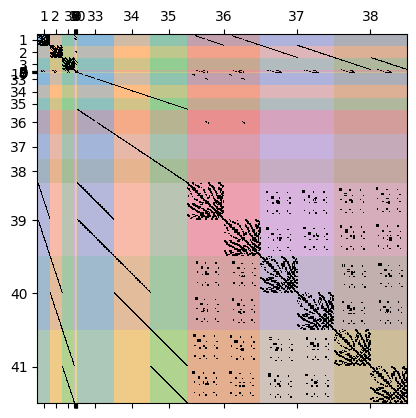

In [5]:
dim_max = model.mdg.dim_max()
sd_ambient = model.mdg.subdomains(dim=dim_max)
sd_lower = [k for i in reversed(range(0, dim_max)) for k in model.mdg.subdomains(dim=i)]
sd_frac = model.mdg.subdomains(dim=dim_max - 1)
intf = model.mdg.interfaces()
intf_frac = model.mdg.interfaces(dim=dim_max - 1)

var_idx = get_variables_indices(
    variable_to_idx=make_variable_to_idx(model),
    md_variables_groups=[
        [model.pressure(sd_ambient)],
        [model.displacement(sd_ambient)],
        [model.pressure(sd_lower)],
        [model.interface_darcy_flux(intf)],
        [model.contact_traction(sd_frac)],
        [model.interface_displacement(intf_frac)],
    ],
)

eq_idx = get_equations_indices(
    equation_to_idx=make_equation_to_idx(model),
    equations_group_order=[
        [("mass_balance_equation", sd_ambient)],  # 0
        [("momentum_balance_equation", sd_ambient)],  # 1
        [("mass_balance_equation", sd_lower)],  # 2
        [("interface_darcy_flux_equation", intf)],  # 3
        [
            ("normal_fracture_deformation_equation", sd_lower),  # 4
            ("tangential_fracture_deformation_equation", sd_lower),
        ],
        [("interface_force_balance_equation", intf)],  # 5
    ],
)

# diagnostics = model.run_diagnostics(grouping='dense')
# model.plot_diagnostics(diagnostics, key='max')
# plot_mat(concatenate_blocks(block_matrix, eq_idx[3], var_idx[3]))
color_spy(
    block_matrix,
    eq_idx[2] + eq_idx[4] + eq_idx[5],
    var_idx[2] + var_idx[4] + var_idx[5],
); plt.show()
x = concatenate_blocks(
    block_matrix,
    eq_idx[2] + eq_idx[4] + eq_idx[5],
    var_idx[2] + var_idx[4] + var_idx[5],
)
# plot_eigs(x)

0.023437500000061236


/home/porepy/simulations/plot_utils.py:88: RuntimeWarning: divide by zero encountered in log10
  mat = np.log10(abs(mat))


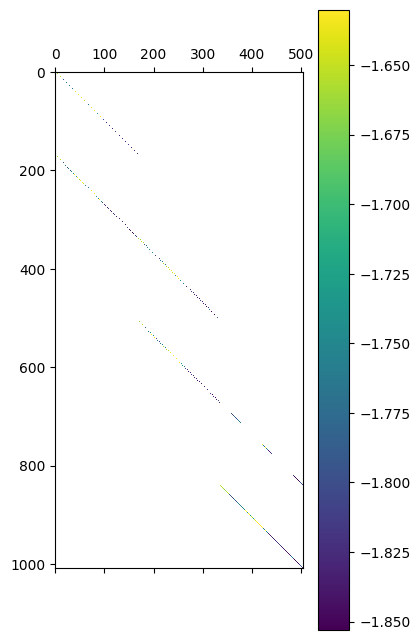

In [6]:
# %matplotlib widget
x = concatenate_blocks(
    block_matrix,
    eq_idx[5],
    # var_idx[3],
    var_idx[4],
    # var_idx[0] + var_idx[1],
)
print(abs(x).max())

plot_mat(x, log=True)
# spy(x)

In [67]:
submats = []
for k in eq_idx:
    row = []
    for j in var_idx:
        row.append(concatenate_blocks(block_matrix, k, j))
    submats.append(row)
submats = np.array(submats, dtype=object)

Solve jacobi prec took: 0.0
Solve diag inv took: 0.0


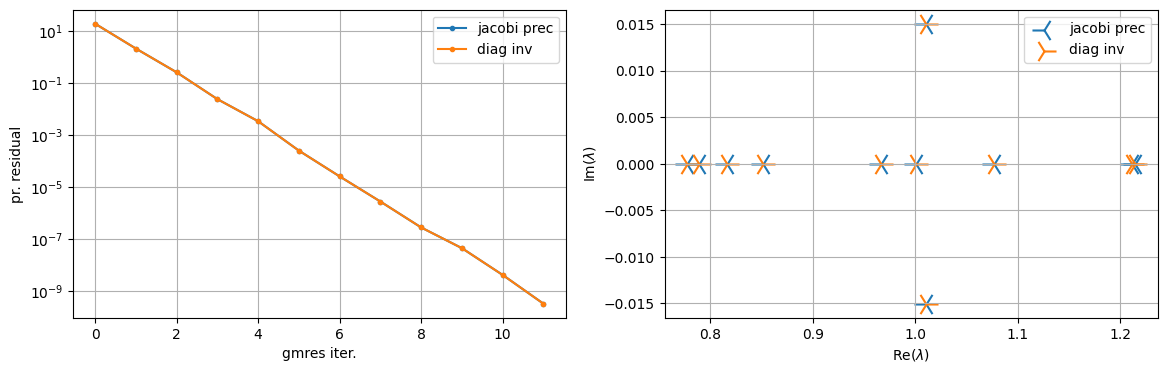

In [85]:
# 1. eliminate block 3,3

J_33_inv = extract_diag_inv(submats[3, 3])
# solve_petsc(submats[3, 3], label='noprec')
solve_petsc(submats[3, 3], PetscJacobi(submats[3, 3]), label='jacobi prec')
solve_petsc(submats[3, 3], J_33_inv, label='diag inv')

hori = concatenate_blocks(submats, rows=[3])
vert = concatenate_blocks(submats, cols=[3])

J_no_33 = []
for k in [0, 1, 2, 4, 5]:
    row = []
    for j in [0, 1, 2, 4, 5]:
        res = submats[k, j] - submats[k, 3] @ J_33_inv @ submats[3, j]
        row.append(res)
    J_no_33.append(row)

In [94]:
F = concatenate_blocks(J_no_33, [2, 3, 4], [2, 3, 4])


1.0000000000000797

In [213]:
import numpy as np


class BlockMatrixStorage:
    def __init__(self, mat, row_idx, col_idx, groups_col, groups_row):
        self.mat = mat
        self.local_row_idx = row_idx
        self.local_col_idx = col_idx
        self.groups_col = groups_col
        self.groups_row = groups_row

    @property
    def shape(self):
        return self.mat.shape 
    
    def __repr__(self) -> str:
        return f'BlockMatrixStorage of shape {self.shape} with {self.mat.nnz} elements'

    def __getitem__(self, key):
        assert isinstance(key, tuple)
        assert len(key) == 2

        def correct_key(k):
            if isinstance(k, slice):
                start = k.start or 0
                stop = k.stop or len(self.groups_row)
                step = k.step or 1
                k = list(range(start, stop, step))
            try:
                iter(k)
            except:
                k = [k]
            return k

        i, j = key
        i = correct_key(i)
        j = correct_key(j)

        row_idx = []
        local_row_idx = [None] * len(self.local_row_idx)
        offset = 0
        for i1 in i:
            for b_row_idx in self.groups_row[i1]:
                assert self.local_row_idx[b_row_idx] is not None, f"Taking inactive row {i1}"
                row_idx.append(self.local_row_idx[b_row_idx])
                local_row_idx[b_row_idx] = np.arange(len(self.local_row_idx[b_row_idx])) + offset
                offset += len(self.local_row_idx[b_row_idx])
        col_idx = []
        local_col_idx = [None] * len(self.local_col_idx)
        offset = 0
        for j1 in j:
            for b_col_idx in self.groups_col[j1]:
                assert self.local_col_idx[b_col_idx] is not None, f"Taking inactive col {j1}"
                col_idx.append(self.local_col_idx[b_col_idx])
                local_col_idx[b_col_idx] = np.arange(len(self.local_col_idx[b_col_idx])) + offset
                offset += len(self.local_col_idx[b_col_idx])

        row_idx = np.concatenate(row_idx)
        col_idx = np.concatenate(col_idx)
        I, J = np.meshgrid(row_idx, col_idx, sparse=True, indexing="ij")
        submat = self.mat[I, J]
        return BlockMatrixStorage(
            mat=submat,
            row_idx=local_row_idx,
            col_idx=local_col_idx,
            groups_col=self.groups_col,
            groups_row=self.groups_row,
        )


row_idx = []
J = BlockMatrixStorage(
    bmat(block_matrix),
    row_idx=eq_dofs,
    col_idx=var_dofs,
    groups_row=eq_idx,
    groups_col=var_idx,
)

In [218]:
J33 = J[3, 3]
J33_inv = extract_diag_inv(J33.mat)
no_3 = [0, 1, 2, 4, 5]
stab = J[no_3, 3].mat @ J33_inv @ J[3, no_3].mat
J_no_33 = J[no_3, no_3]
J_no_33.mat -= stab

In [235]:
mech = [1]
flow = [0]
mechflow = mech + flow
other = [2, 4, 5]
Omega = J_no_33[mechflow, mechflow]
Phi = J_no_33[other, mechflow]
Psi = J_no_33[mechflow, other]
F = J_no_33[other, other]

F_inv = inv(F.mat)

stab2 = Psi.mat @ F_inv @ Phi.mat

Omega.mat -= stab2

Ap = Omega[flow, flow]
Bp = Omega[mech, mech]
C1p = Omega[flow, mech]
C2p = Omega[mech, flow]

S_Ap = Ap.mat.copy()
S_Ap += get_fixed_stress_stabilization(model)

Bp_inv = PetscAMGMechanics(dim=model.nd, mat=Bp.mat)
S_Ap_fs_inv = PetscAMGFlow(mat=S_Ap)

Omega_p_inv_fstress = OmegaInv(
    solve_momentum=Bp_inv,
    solve_mass=S_Ap_fs_inv,
    C1=C1p.mat,
    C2=C2p.mat,
)

preconditioner = UpperBlockPreconditioner(
    F_inv=F_inv, Omega_inv=Omega_p_inv_fstress, Phi=Phi.mat
)

reordered_mat = J_no_33[other + mech + flow, other + mech + flow].mat
# # reordered_mat = concatenate_blocks(
# #     block_matrix,
# #     eq_blocks[2] + eq_blocks[1] + eq_blocks[0],
# #     var_blocks[2] + var_blocks[1] + var_blocks[0],
# # )

# reordered_mat = self.permutation @ mat @ self.permutation.T

Solve  took: 3.27


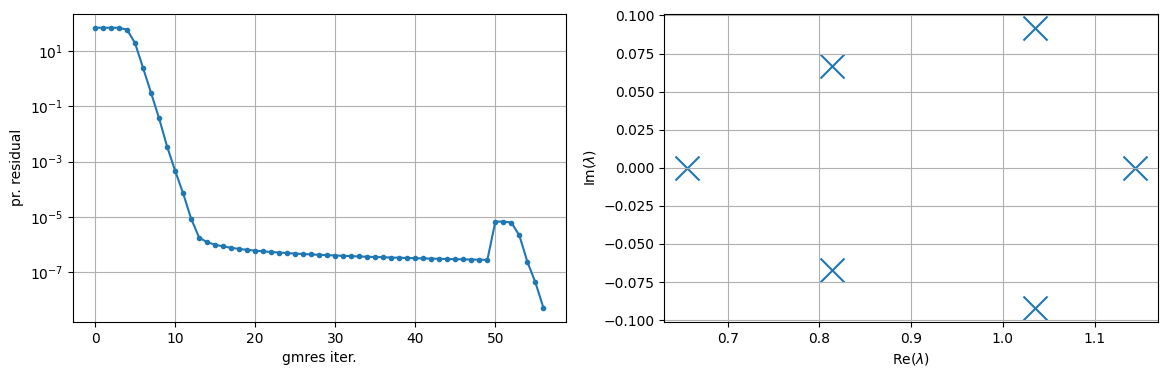

In [237]:
solve_petsc(reordered_mat, preconditioner, logx_eigs=False)

Solve  took: 3.34


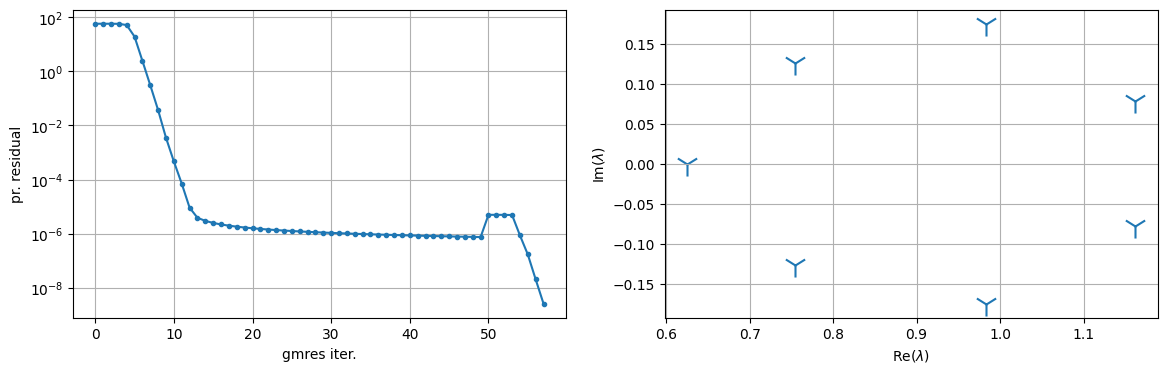

In [239]:
solve_petsc(Omega.mat, Omega_p_inv_fstress, logx_eigs=False)

Solve  took: 2.9
PETSc Converged Reason: -5


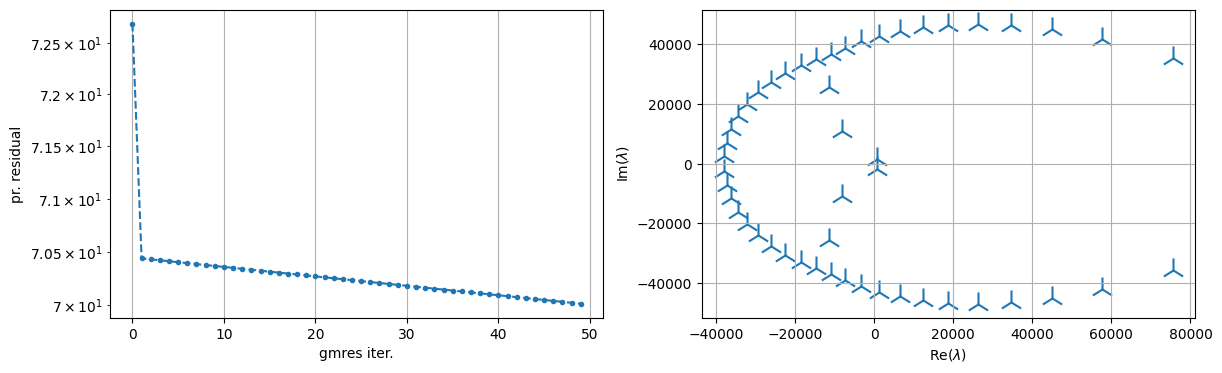

In [241]:
preconditioner_full = UpperBlockPreconditioner(
    F_inv=J33_inv, Omega_inv=preconditioner, Phi=J[3, no_3].mat
)

solve_petsc(J[[3] + other + mech + flow, [3] + other + mech + flow].mat, preconditioner_full)

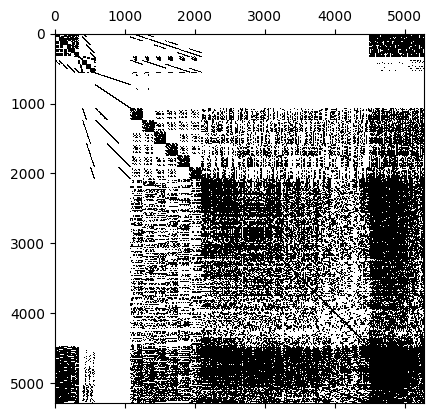

In [242]:
spy(J[[3] + other + mech + flow, [3] + other + mech + flow].mat)